<a href="https://colab.research.google.com/github/victor-armegioiu/Time-Series-Prediction/blob/main/VK_Energie__Conv_Bayesian_NN_(Uncertainty_Plots)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Praktikum Project (VK Energie - Forecasting Heat Demand)

# Boilerplate 

This section does necesary imports, loads/parses the data.

In [1]:
# Non-neural based math imports.
import time
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import scipy 
from scipy import stats

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
# Data loading
import pandas as pd
import csv

In [3]:
# Drawing stuff.
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#matplotlib.style.use('ggplot')

In [4]:
# Neural networks stuff.
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

In [5]:
df = pd.DataFrame()
reader = csv.reader(
    open("Oberbayern.csv"), delimiter=";")

rows = [row for row in reader]
df = df.append(rows[1:])

In [6]:
df.columns = ['TimestampUtc', 'Heat Demand', 'Ambient Temperature',  
              'Solar Irradiance']

In [7]:
for column in df.columns[1:]:
  df[column] = df[column].astype(float)

# Data Analysis

This section covers the following analyses on the dataset:


*   Peaking at samples from the data.
*   Missing values count
*   Overall statistics on the regressors/regressands (mean, max, std, etc). Plots for the histograms.
*   Correlation analysis - Making sure the correlations between the features and the targets make sense, as well as ensuring we don't have too strong a linear correlation between the features. 



In [8]:
df

,TimestampUtc,Heat Demand,Ambient Temperature,Solar Irradiance
0,2020-02-26 17:00:00+01:00,5715.7325,1.370000,0.050000
1,2020-02-26 18:00:00+01:00,5810.5000,0.880000,0.000000
2,2020-02-26 19:00:00+01:00,6059.9000,0.670000,0.000000
3,2020-02-26 20:00:00+01:00,6114.0850,0.600000,0.000000
4,2020-02-26 21:00:00+01:00,6027.0525,0.540000,0.000000
...,...,...,...,...
5941,2020-11-02 12:00:00+01:00,3431.5000,16.787415,5.718750
5942,2020-11-02 13:00:00+01:00,3221.2500,16.833160,7.406250
5943,2020-11-02 14:00:00+01:00,3153.7500,16.731232,2.312500
5944,2020-11-02 15:00:00+01:00,2795.1250,16.396759,7.906250


In [ ]:
df.isnull().sum()

TimestampUtc           0
Heat Demand            0
Ambient Temperature    0
Solar Irradiance       0
dtype: int64

In [ ]:
df.columns

Index(['TimestampUtc', 'Heat Demand', 'Ambient Temperature',
       'Solar Irradiance'],
      dtype='object')

In [ ]:
# Compute and store pairwise correlations between features and
# targets.
correlations = {}
for col1 in df.columns[1:]:
  for col2 in df.columns[1:]:
    if col1 != col2:
      r2_correlation_coeff = stats.pearsonr(df[col1], df[col2])[0]
      correlations[col1, col2] = r2_correlation_coeff

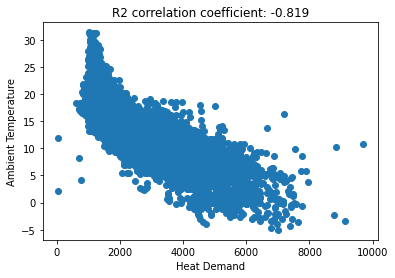

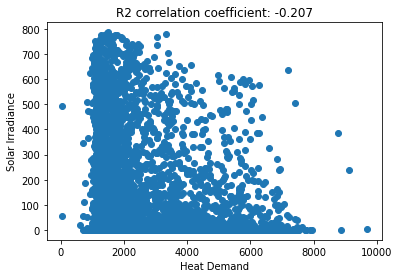

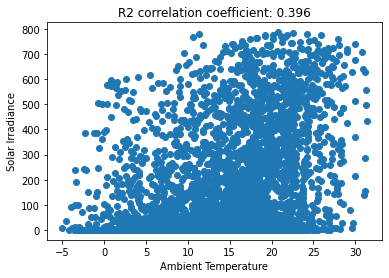

In [ ]:
# Plot all pairwise features/targets/
relevant_columns = df.columns[1:] 

for i in range(len(relevant_columns)):
  for j in range(i + 1, len(relevant_columns)):
    col_i, col_j = relevant_columns[i], relevant_columns[j]
    plt.scatter(df[col_i], df[col_j])
    plt.xlabel(col_i)
    plt.ylabel(col_j)

    r2_correlation_coeff = round(correlations[col_i, col_j], 3)
    plt.title('R2 correlation coefficient: {}'.format(r2_correlation_coeff))
    plt.show()


count    5946.000000
mean     2753.058015
std      1530.114730
min        43.000000
25%      1514.583328
50%      2222.491250
75%      3754.158808
max      9681.533203
Name: Heat Demand, dtype: float64


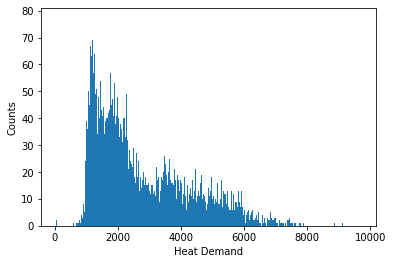


count    5946.000000
mean       13.007976
std         6.339653
min        -5.020000
25%         8.600000
50%        13.198389
75%        17.370000
max        31.371857
Name: Ambient Temperature, dtype: float64


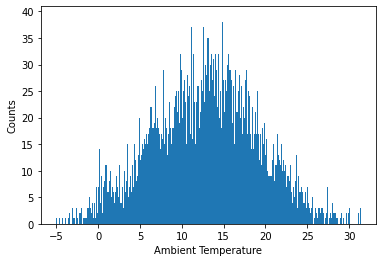


count    5946.000000
mean      105.020707
std       184.026273
min        -0.260000
25%         0.000000
50%         1.812500
75%       131.907500
max       787.470000
Name: Solar Irradiance, dtype: float64


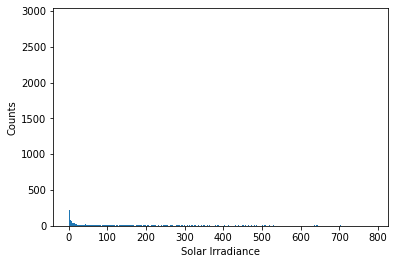

In [ ]:
for column in df.columns[1:]:
  print(df[column].describe())
  plt.hist(df[column], bins=500)
  plt.xlabel(column)
  plt.ylabel('Counts')
  plt.show()
  print()

# Building datasets for training

This section covers the setup needed for creating datasets than can be fed to Pytorch NNs. We also do some preprocessing shift/scale our inputs.

In [9]:
def DfTrainTestSplitter(df, test_proportion=0.2, as_numpy=True):
  """Split dataframe into train and test data.
  
  In order to have the test distribution as close as possible to th
  train distribution, we split the initial datafram into 4 chunks,
  one corresponding from each season.

  We build the test set by concatenating random samples from each season.
  """
  cnt_test = int(test_proportion * len(df))
  season_cnt = 4
  df_train, df_test = None, None

  for i in range(season_cnt):
    left_idx = i * int(len(df) / season_cnt)
    right_idx = min(int(left_idx + cnt_test // 4.0), len(df) - 2)
    
    if df_test is None:
      df_test = df[left_idx: right_idx + 1]
    else:
      df_test = pd.concat([df_test, df[left_idx: right_idx + 1]])

  df_train = pd.concat([df, df_test]).drop_duplicates(keep=False)
  if as_numpy:
   return df_train.to_numpy()[:, 1:],  df_test.to_numpy()[:, 1:]
  return df_train, df_test

In [10]:
train_data, test_data = DfTrainTestSplitter(df, test_proportion=0.1)
X_train, y_train = (train_data[:, [1, 2]].astype(float),
                    train_data[:, 0].astype(float))

X_test, y_test = (test_data[:, [1, 2]].astype(float),
                  test_data[:, 0].astype(float))

In [11]:
X_train.shape, X_test.shape

((5350, 2), (596, 2))

In [12]:
scaler = MinMaxScaler().fit(X_train)

In [13]:
# Use the same scaler in order to ensure that we don't inject knowledge
# about the test distribution in our training biases.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

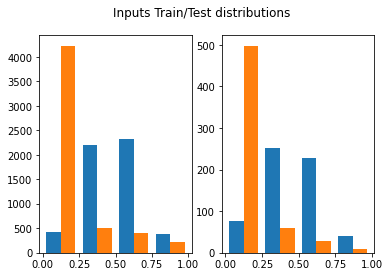

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Inputs Train/Test distributions')
ax1.hist(X_train, bins=4)
ax2.hist(X_test, bins=4)
plt.show()

In [15]:
# Scale both dataset by `y_train_max`. Same reasoning
# as in using the same scaler on inputs. This is done to avoid
# exploding gradients.
y_train_max = y_train.max()
y_train /= y_train_max
y_test /= y_train_max

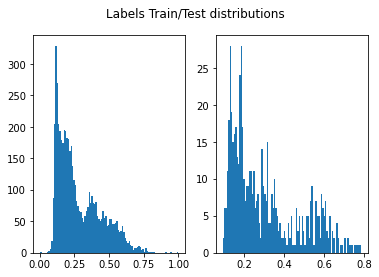

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Labels Train/Test distributions')
ax1.hist(y_train, bins=100)
ax2.hist(y_test, bins=100)
plt.show()

# Batching Logic 

This section defines the necessary utilities for producing batches of variable length sequences.

In [17]:
def GetInitialBatchIndex(X, input_len, prediction_window_len=48):
  """ 
      Returns a random index from which to sample `input_len` inputs.
      This was written separately so that we can test that it produces an
      even distribution among potential starting indices.
  """
  left_idx = np.random.randint(
      low=0,
      high=max(len(X) - prediction_window_len * 2 - input_len - 1, 1))
  right_idx = left_idx + input_len - 1
  return left_idx

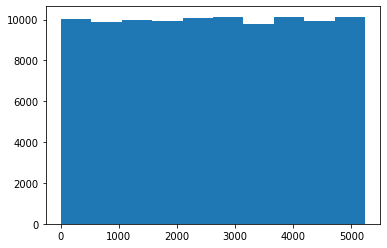

In [18]:
# Confirm that starting indices for bathches are evenly distributed.
no_trials = 100000
start_indices_samples = []

for _ in range(no_trials):
  start_indices_samples.append(GetInitialBatchIndex(X_train, 15))

plt.hist(start_indices_samples)
plt.show()

In [19]:
def GetSample(X, y, input_len, prediction_window_len=48, use_noise_reg=False):
  """Return a single input sequence and its respective targets.
  
  Args:
    X: np.array from which to extract input sequences.
    y: np.array from which to extract the regression targets corresponding
       to the selected inputs.
    prediction_window_len: length of the prediction window, which describes
      how many predictions we have to do for a given input sequence.
    use_noise_reg: bool indication whether to inject the labels with noise.

  Return:
    X_tensor: tensorized inputs.
    y_tensor: tensorized targets.

  Note, since we can use forecasts, we also include future data in our
  sequences.
  """
  left_idx = GetInitialBatchIndex(X, input_len, prediction_window_len)
  right_idx = left_idx + input_len - 1

  # Add `prediction_window_len` to our right index, since we can use future
  # values as well, given that we always expect to have forecasts availabel.
  X_sample = X[left_idx : right_idx + 1 + prediction_window_len]
  y_sample = y[right_idx + 1 : right_idx + prediction_window_len + 1]

  return X_sample, y_sample

In [20]:
def GetBatch(X, y, batch_size, input_len, prediction_window_len=48,
             use_noise_reg=False):
  Xs, ys = [], []
  for _ in range(batch_size):
    X_sample, y_sample = GetSample(X, y, 
                                   input_len,
                                   prediction_window_len,
                                   use_noise_reg)
    Xs.append(X_sample)
    ys.append(y_sample)
  return np.stack(Xs), np.stack(ys)vk en

In [21]:
xb, yb = GetBatch(X_train, y_train, 10, 1)
xb.shape, yb.shape

((10, 49, 2), (10, 48))

# Neural Models Definitions

We set up a small Bayesian Neural Net, train it via variational inference using a flipout estimator ([Wen et. al, 2018], it costs `2x` more floating point computations than typical reparameterization, but has less variance).


In [22]:
tf.keras.backend.clear_session()

# Training params.
epochs = 20
batch_size = 32
val_batch_size = 10
seq_len = 1
prediction_window_len = 48
input_shape = (49, 2)

iter_per_epochs = len(X_train) // batch_size

# Loss, optimizer and divergence function to use for variational layers.
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer=tf.keras.optimizers.Adam(0.001)

kl_divergence_function = (lambda q, p, _:
                          tfp.distributions.kl_divergence(q, p) /
                          tf.cast(len(X_train), dtype=tf.float32))
train_acc_metric = tf.keras.metrics.MeanAbsoluteError()
val_acc_metric = tf.keras.metrics.MeanAbsoluteError()

# Bayesian Convolutional NN.
model_tfp = tf.keras.Sequential([
    tf.keras.Input(shape=input_shape,name="input"),
    tfp.layers.Convolution1DFlipout(
        64, kernel_size=5, padding='SAME', activation=tf.nn.relu,
        kernel_divergence_fn=kl_divergence_function),
    tfp.layers.Convolution1DFlipout(
        32, kernel_size=3, padding='SAME', activation=tf.nn.relu,
        kernel_divergence_fn=kl_divergence_function),    
    tf.keras.layers.Flatten(),
    tfp.layers.DenseFlipout(prediction_window_len,
                            kernel_divergence_fn=kl_divergence_function,
                            activation=tf.nn.relu, name="out_tfp_pred"),
])

for epoch in range(epochs):
    start_time = time.time()
    print("\nStart of epoch %d" % (epoch,))

    for iter in range(iter_per_epochs):
        with tf.GradientTape() as tape:
            x_batch_train, y_batch_train = GetBatch(X_train, y_train,
                                                    batch_size, seq_len)
            logits = model_tfp(x_batch_train, training=True)
            loss_value = loss_fn(y_batch_train, logits)

        grads = tape.gradient(loss_value, model_tfp.trainable_weights)

        optimizer.apply_gradients(zip(grads, model_tfp.trainable_weights))
        train_acc_metric.update_state(y_batch_train, logits)

        if iter % 20 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (iter, float(loss_value))
            )
            print("Seen so far: %s samples" % ((iter + 1) * batch_size))

    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))

    train_acc_metric.reset_states()

    # Get 5 batches for validation.
    val_batches = [GetBatch(X_test, y_test, 
                            val_batch_size, seq_len) for _ in range(5)]
    for x_batch_val, y_batch_val in val_batches:
        val_logits = model_tfp(x_batch_val, training=False)
        val_acc_metric.update_state(y_batch_val, val_logits)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Time taken: %.2fs" % (time.time() - start_time))
      

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '



Start of epoch 0
Training loss (for one batch) at step 0: 0.1590
Seen so far: 32 samples
Training loss (for one batch) at step 20: 0.0529
Seen so far: 672 samples
Training loss (for one batch) at step 40: 0.0363
Seen so far: 1312 samples
Training loss (for one batch) at step 60: 0.0303
Seen so far: 1952 samples
Training loss (for one batch) at step 80: 0.0177
Seen so far: 2592 samples
Training loss (for one batch) at step 100: 0.0159
Seen so far: 3232 samples
Training loss (for one batch) at step 120: 0.0246
Seen so far: 3872 samples
Training loss (for one batch) at step 140: 0.0143
Seen so far: 4512 samples
Training loss (for one batch) at step 160: 0.0150
Seen so far: 5152 samples
Training acc over epoch: 0.1335
Validation acc: 0.0850
Time taken: 12.06s

Start of epoch 1
Training loss (for one batch) at step 0: 0.0155
Seen so far: 32 samples
Training loss (for one batch) at step 20: 0.0163
Seen so far: 672 samples
Training loss (for one batch) at step 40: 0.0107
Seen so far: 1312 sa

In [70]:
X_sample, y_sample = GetBatch(X_test, y_test, 1, seq_len)

Mean Absolute Error: 355.0710785437739


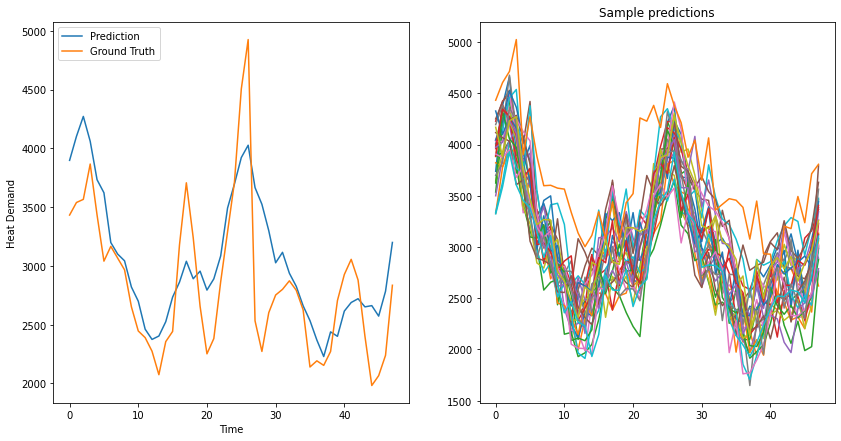

In [71]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

ax1.set_ylabel('Heat Demand')
ax1.set_xlabel('Time')
ax2.set_title('Sample predictions')

# Number of times to sample new parameters and compute predictions.
no_trials = 30
preds = []
for i in range(no_trials):
  preds.append(model_tfp.predict(X_sample).flatten())
  ax2.plot(preds[-1].flatten() * y_train_max)

# Get average prediction.
avg_preds = np.mean(np.array(preds), axis=0)

ax1.plot(avg_preds.flatten() * y_train_max)
ax1.plot(y_sample.flatten() * y_train_max)
ax1.legend(['Prediction', 'Ground Truth'], loc='upper left')

mae = tf.math.reduce_mean(tf.abs(avg_preds - y_sample) * y_train_max).numpy()
print('Mean Absolute Error:', mae)

plt.show()

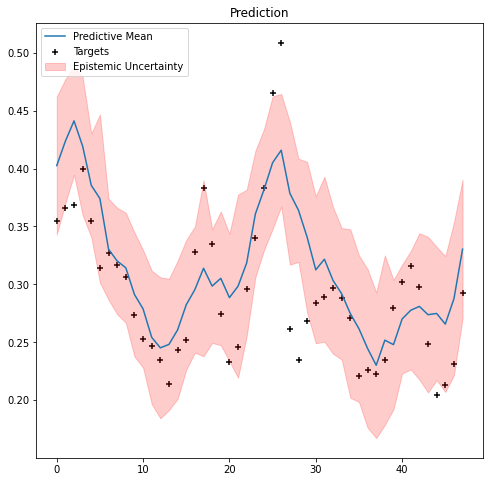

In [74]:
# Plot mean and std.
plt.figure(figsize=(8, 8))
y_std = np.std(np.array(preds), axis=0)
plt.plot(avg_preds, label='Predictive Mean')
plt.scatter(range(0, 48), y_sample, label='Targets', marker='+', color='black')
plt.fill_between(range(0, 48),
                 avg_preds - 2 * y_std, avg_preds + 2 * y_std,
                 color='red', alpha=0.2, label='Epistemic Uncertainty')
plt.title('Prediction')
plt.legend(loc='upper left')
plt.show()